In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES=True

## fish vs cats classifier

every dataset, no matter what, can interact with pytorch if it satisfies this abstract class:
        
        class Dataset(object):
            def __getitem__(self, index):
                raise NotImplementedError

            def __len__(self):
                raise NotImplmentedError

This is fairly straightforward, we have to implement a method that returns the size of our dataset (`len`), and implement a method that can retrieve an item from our dataset in a (`label, tensor`) pair. This is called the **data loader** as it is pushing data into the neural network for training. 

So we have to write a body for `getitem` that can take an image and transofrm it into a tensor and return that and the label back so that pytorch can operate on it.


### Building a training dataset
The `torchvision` package includes a class called `ImageFolder` that does pretty much everything for us, provided our images are in a structure where each directory is a lable (e.g., all cats are in a directory called cat)

For our cats and fishes example, here's what you you need 

In [40]:
import torch
import torchvision
from torchvision import datasets, transforms

train_path = './train'

transforms = transforms.Compose([
    transforms.Resize((64, 64)),  # Fixed size: (height, width)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(root=train_path, transform=transforms)

`torchvision` allows you to specify a list of transforms that will be applied to the image before it gets fed into the neural network. 

The default transform is to take image data and turn it into a tensor, the `Transforms.ToTensor()` method seen in the previous code, but we're doing a couple of other things that might not seem obvious. 

1. First - GPUS are built to be fast at performing calculations that are a standard size. But we probably have an assortment of images at many resolutions. To increase our processing performance, we scale every incoming image to the same resolution of 64 x 64 via the  `Resize(64)` transform. 
2. We then convert the images to a tensor, and 
3. Finally, we normalize the tensor around a specific set of mean and standard deviation points... keeping the incoming values between 0 and 1 to avoid exploding gradients.

## Building Validation and Test Datasets

In [41]:
val_data_path = './val'
val_data = datasets.ImageFolder(root=val_data_path, transform=transforms)

test_data_path = './test'
test_data = datasets.ImageFolder(root=test_data_path, transform=transforms)

we can then build our dataloaders with a few more lines:

In [42]:
from torch.utils.data import Dataset, DataLoader

batch_size = 64 # set batch size 

train_data_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=False # set to True if using CUDA
)

val_data_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=False # set to True if using CUDA
)

test_data_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=False # set to True if using CUDA
)

### More on dataloaders:
- By default - pytorch dataloaders use a batch size of 1
- you might want to experiment to see how much your GPU can actually handle

## Simple Neural Networks

1. Creating a Network: Creating a network in pytorch is a very pythonic affair. We inherit from a class called `torch.nn.Network` and fill out the `__init__` and `forward` methods:

### Walking through this one: 

1. We do any setup required in `init()`, in this case calling our superclass constructor and the tree fully connected layers (called `Linear` in pytorch, as opposed to `Dense` in keras)
2. The `forward()` method describes how data flows through the network in both training and making predictions (*inference*).
- First we have to convert the 3d tensor (x plus y plus three-channel color information (red, green, blue)) -- into a 1D tensor so that it can be fed into the first `linear` layer.
- From there you can see that we apply the layers and the activation functions in order, finally returning the `softmax` output to give us our predictions for that image.

### Loss Functions
Pytorch uses loss functions to determine how it will update the ntework to reach the desired results. 

We'll start with 2 common ones `CrossEntropyLoss` - which is recommended for multiclass categorization tasks like we're doing here. 

Another loss function you're likely to come across is `MSELoss` which is a standard mean squared loss that you might use when making a numerical prediction. 

one thing to be aware of is that `CrossEntropyLoss` also incorporates `softmax()`, so our forward method becomes the following:

### Optimizers
Creating an adam based optimizer is simple. We call `optim.Adam()` and pass in the weights of the network that it will be updating Z(obtained via `simplenet.parameters())` and our example learning rate of 0.01)

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# basic neural network 

class SimpleNet(nn.Module):

    def __init__(self):
        super().__init__()  # Modern Python 3+ syntax - cleaner!
        self.fc1 = nn.Linear(12288, 84)
        self.fc2 = nn.Linear(84, 50)
        self.fc3 = nn.Linear(50, 2)

    def forward(self, x):
        x = x.view(-1, 12288)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No softmax here - CrossEntropyLoss includes it
        return x
    
simplenet = SimpleNet()
optimizer = optim.Adam(simplenet.parameters(), lr=0.001)

## Training loop 
- Write as a function so parts such as the loss function and optimizer can be passed in as parameters.
- To compute gradients, we call the `backward()` method on the model 
- The `optimizer.step()` method uses those gradients afterward to perform the adjustment of the weights that we talked about in the previous section
- What about `zero_grad()`? turns out the the calcuated gradients accumulate by default, so we use `zero_grad()` to make sure they are reset to zero after we're done with our loop.

In [45]:
# training loop
from tqdm import tqdm

def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device='mps'):
    # Move model and loss function to device
    model = model.to(device)
    loss_fn = loss_fn.to(device)
    
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()

        # Progress bar for training
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
        for batch in train_pbar:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item()
            
            # Update progress bar with current loss
            train_pbar.set_postfix({'loss': loss.item()})
        
        training_loss /= len(train_loader)

        model.eval()
        num_correct = 0
        num_examples = 0

        # Progress bar for validation
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]')
        for batch in val_pbar:
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            valid_loss += loss.data.item()
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
            
            # Update progress bar
            val_pbar.set_postfix({'loss': loss.item()})
        
        valid_loss /= len(val_loader)
        valid_acc = num_correct / num_examples

        print(f'Epoch {epoch+1}/{epochs} - Train Loss: {training_loss:.4f}, Val Loss: {valid_loss:.4f}, Val Acc: {valid_acc:.4f}')

In [37]:
train(simplenet, optimizer, torch.nn.CrossEntropyLoss(), train_data_loader, test_data_loader, device='mps')

Epoch 1/20 [Val]: 100%|██████████| 4/4 [00:22<00:00,  5.60s/it, loss=1.18] 


Epoch 1/20 - Train Loss: 0.4191, Val Loss: 0.7869, Val Acc: 0.6603


Epoch 2/20 [Val]: 100%|██████████| 4/4 [00:22<00:00,  5.60s/it, loss=0.642]


Epoch 2/20 - Train Loss: 0.3698, Val Loss: 0.6709, Val Acc: 0.6794


Epoch 3/20 [Val]: 100%|██████████| 4/4 [00:22<00:00,  5.61s/it, loss=0.805]


Epoch 3/20 - Train Loss: 0.2712, Val Loss: 0.7325, Val Acc: 0.7033


Epoch 4/20 [Val]: 100%|██████████| 4/4 [00:22<00:00,  5.61s/it, loss=1.47] 


Epoch 4/20 - Train Loss: 0.2108, Val Loss: 0.9135, Val Acc: 0.6603


Epoch 5/20 [Val]: 100%|██████████| 4/4 [00:22<00:00,  5.63s/it, loss=0.941]


Epoch 5/20 - Train Loss: 0.1531, Val Loss: 0.8431, Val Acc: 0.6986


Epoch 6/20 [Val]: 100%|██████████| 4/4 [00:22<00:00,  5.60s/it, loss=1.86] 


Epoch 6/20 - Train Loss: 0.1168, Val Loss: 1.1263, Val Acc: 0.6746


Epoch 7/20 [Val]: 100%|██████████| 4/4 [00:22<00:00,  5.60s/it, loss=1.85] 


Epoch 7/20 - Train Loss: 0.0949, Val Loss: 1.1279, Val Acc: 0.6938


Epoch 8/20 [Val]: 100%|██████████| 4/4 [00:22<00:00,  5.60s/it, loss=2.32] 


Epoch 8/20 - Train Loss: 0.0612, Val Loss: 1.3313, Val Acc: 0.6986


Epoch 9/20 [Val]: 100%|██████████| 4/4 [00:22<00:00,  5.61s/it, loss=1.78]


Epoch 9/20 - Train Loss: 0.0445, Val Loss: 1.2425, Val Acc: 0.6890


Epoch 10/20 [Val]: 100%|██████████| 4/4 [00:22<00:00,  5.61s/it, loss=2.34] 


Epoch 10/20 - Train Loss: 0.0265, Val Loss: 1.3920, Val Acc: 0.6890


Epoch 11/20 [Val]: 100%|██████████| 4/4 [00:22<00:00,  5.64s/it, loss=2.45] 


Epoch 11/20 - Train Loss: 0.0162, Val Loss: 1.4610, Val Acc: 0.7033


Epoch 12/20 [Val]: 100%|██████████| 4/4 [00:22<00:00,  5.62s/it, loss=2.49]


Epoch 12/20 - Train Loss: 0.0158, Val Loss: 1.5339, Val Acc: 0.7033


Epoch 13/20 [Val]: 100%|██████████| 4/4 [00:22<00:00,  5.60s/it, loss=2.93] 


Epoch 13/20 - Train Loss: 0.0138, Val Loss: 1.6631, Val Acc: 0.6986


Epoch 14/20 [Val]: 100%|██████████| 4/4 [00:22<00:00,  5.67s/it, loss=2.92]


Epoch 14/20 - Train Loss: 0.0100, Val Loss: 1.7018, Val Acc: 0.6938


Epoch 15/20 [Val]: 100%|██████████| 4/4 [00:22<00:00,  5.62s/it, loss=2.75]


Epoch 15/20 - Train Loss: 0.0067, Val Loss: 1.6824, Val Acc: 0.6938


Epoch 16/20 [Val]: 100%|██████████| 4/4 [00:22<00:00,  5.61s/it, loss=3.04]


Epoch 16/20 - Train Loss: 0.0043, Val Loss: 1.7880, Val Acc: 0.6842


Epoch 17/20 [Val]: 100%|██████████| 4/4 [00:22<00:00,  5.61s/it, loss=3.3] 


Epoch 17/20 - Train Loss: 0.0029, Val Loss: 1.8697, Val Acc: 0.6890


Epoch 18/20 [Val]: 100%|██████████| 4/4 [00:22<00:00,  5.62s/it, loss=3.35]


Epoch 18/20 - Train Loss: 0.0026, Val Loss: 1.9024, Val Acc: 0.6842


Epoch 19/20 [Val]: 100%|██████████| 4/4 [00:22<00:00,  5.61s/it, loss=3.32]


Epoch 19/20 - Train Loss: 0.0023, Val Loss: 1.9105, Val Acc: 0.6842


Epoch 20/20 [Val]: 100%|██████████| 4/4 [00:22<00:00,  5.62s/it, loss=3.31]

Epoch 20/20 - Train Loss: 0.0018, Val Loss: 1.9337, Val Acc: 0.6842


In [38]:
def evaluate_test(model, test_loader, device='mps'):
    """Evaluate the model on the test set."""
    model = model.to(device)
    model.eval()
    
    num_correct = 0
    num_examples = 0
    
    # No gradient calculation needed for evaluation
    with torch.no_grad():
        test_pbar = tqdm(test_loader, desc='Testing')
        for batch in test_pbar:
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Forward pass
            output = model(inputs)
            
            # Get predictions (class with highest probability)
            predictions = torch.max(output, dim=1)[1]
            
            # Calculate accuracy
            correct = torch.eq(predictions, targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
            
            # Update progress bar
            test_pbar.set_postfix({'accuracy': num_correct / num_examples})
    
    test_acc = num_correct / num_examples
    print(f'\n{"="*50}')
    print(f'Test Set Evaluation')
    print(f'{"="*50}')
    print(f'Total Examples: {num_examples}')
    print(f'Correct Predictions: {num_correct}')
    print(f'Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)')
    print(f'{"="*50}')
    
    return test_acc

# Run evaluation on test set
test_accuracy = evaluate_test(simplenet, test_data_loader, device='mps')

Testing: 100%|██████████| 4/4 [00:22<00:00,  5.60s/it, accuracy=0.684]


Test Set Evaluation
Total Examples: 209
Correct Predictions: 143
Test Accuracy: 0.6842 (68.42%)


## Test Set Evaluation

Now let's evaluate our trained model on the test set to see how well it generalizes to completely unseen data.

# Refactored: Modern PyTorch Implementation

Below is a more production-ready implementation with:
- Configuration management
- History tracking
- Model checkpointing
- Better code organization
- Learning rate scheduling
- Plotting utilities

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

# Configuration class
class Config:
    """Centralized configuration for the training pipeline."""
    # Data paths
    train_path = './train'
    val_path = './val'
    test_path = './test'
    
    # Model hyperparameters
    input_size = 12288  # 64 * 64 * 3
    hidden1 = 84
    hidden2 = 50
    num_classes = 2
    
    # Training hyperparameters
    batch_size = 64
    learning_rate = 0.001
    epochs = 20
    device = 'mps' if torch.backends.mps.is_available() else 'cpu'
    
    # Data loader settings
    num_workers = 0  # Safe for notebooks
    pin_memory = False
    
    # Model checkpoint
    checkpoint_dir = Path('./checkpoints')
    checkpoint_dir.mkdir(exist_ok=True)
    model_save_path = checkpoint_dir / 'simplenet_best.pth'

config = Config()
print(f"Using device: {config.device}")

Using device: mps


In [49]:
# Data loading function
def get_dataloaders(config):
    """Create train, validation, and test dataloaders."""
    
    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Create datasets
    train_dataset = datasets.ImageFolder(root=config.train_path, transform=transform)
    val_dataset = datasets.ImageFolder(root=config.val_path, transform=transform)
    test_dataset = datasets.ImageFolder(root=config.test_path, transform=transform)
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        pin_memory=config.pin_memory
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=config.pin_memory
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=config.pin_memory
    )
    
    print(f"Train samples: {len(train_dataset)}")
    print(f"Val samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    print(f"Class names: {train_dataset.classes}")
    
    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = get_dataloaders(config)

Train samples: 1023
Val samples: 150
Test samples: 209
Class names: ['cat', 'fish']


In [50]:
# Model definition (same SimpleNet architecture)
class SimpleNet(nn.Module):
    """Simple fully-connected neural network for image classification."""
    
    def __init__(self, input_size=12288, hidden1=84, hidden2=50, num_classes=2):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, num_classes)
    
    def forward(self, x):
        # Flatten image
        x = x.view(x.size(0), -1)
        
        # Hidden layers with ReLU
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        # Output layer (no activation - CrossEntropyLoss handles it)
        x = self.fc3(x)
        return x

# Initialize model
model = SimpleNet(
    input_size=config.input_size,
    hidden1=config.hidden1,
    hidden2=config.hidden2,
    num_classes=config.num_classes
).to(config.device)

print(f"Model: {model}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Model: SimpleNet(
  (fc1): Linear(in_features=12288, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)
Total parameters: 1,036,628


In [52]:
# Training and evaluation functions with history tracking
class Trainer:
    """Handles model training and evaluation with history tracking."""
    
    def __init__(self, model, config):
        self.model = model
        self.config = config
        self.device = config.device
        
        # Loss and optimizer
        self.criterion = nn.CrossEntropyLoss().to(self.device)
        self.optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
        
        # Learning rate scheduler (reduce on plateau)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=3, verbose=True
        )
        
        # History tracking
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'val_acc': [],
            'lr': []
        }
        
        # Best model tracking
        self.best_val_acc = 0.0
    
    def train_epoch(self, train_loader):
        """Train for one epoch."""
        self.model.train()
        running_loss = 0.0
        
        train_pbar = tqdm(train_loader, desc='Training')
        for inputs, targets in train_pbar:
            inputs = inputs.to(self.device)
            targets = targets.to(self.device)
            
            # Forward pass
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, targets)
            
            # Backward pass
            loss.backward()
            self.optimizer.step()
            
            running_loss += loss.item()
            train_pbar.set_postfix({'loss': loss.item()})
        
        return running_loss / len(train_loader)
    
    def validate(self, val_loader):
        """Validate the model."""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc='Validating')
            for inputs, targets in val_pbar:
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)
                
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                
                running_loss += loss.item()
                
                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
                
                val_pbar.set_postfix({'loss': loss.item(), 'acc': correct/total})
        
        val_loss = running_loss / len(val_loader)
        val_acc = correct / total
        
        return val_loss, val_acc
    
    def fit(self, train_loader, val_loader, epochs):
        """Train the model for multiple epochs."""
        print(f"\nStarting training for {epochs} epochs...")
        print(f"{'='*60}\n")
        
        for epoch in range(epochs):
            print(f"Epoch {epoch+1}/{epochs}")
            
            # Train
            train_loss = self.train_epoch(train_loader)
            
            # Validate
            val_loss, val_acc = self.validate(val_loader)
            
            # Update learning rate scheduler
            self.scheduler.step(val_loss)
            
            # Get current learning rate
            current_lr = self.optimizer.param_groups[0]['lr']
            
            # Update history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['lr'].append(current_lr)
            
            # Save best model
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                self.save_checkpoint()
                print(f"✓ New best model saved! Val Acc: {val_acc:.4f}")
            
            # Print epoch summary
            print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | LR: {current_lr:.6f}")
            print(f"{'='*60}\n")
        
        print(f"Training complete! Best Val Acc: {self.best_val_acc:.4f}")
        return self.history
    
    def evaluate(self, test_loader):
        """Evaluate on test set."""
        self.model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            test_pbar = tqdm(test_loader, desc='Testing')
            for inputs, targets in test_pbar:
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)
                
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs, 1)
                
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
                
                test_pbar.set_postfix({'acc': correct/total})
        
        test_acc = correct / total
        
        print(f"\n{'='*60}")
        print(f"Test Set Evaluation")
        print(f"{'='*60}")
        print(f"Total Examples: {total}")
        print(f"Correct Predictions: {correct}")
        print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
        print(f"{'='*60}\n")
        
        return test_acc
    
    def save_checkpoint(self):
        """Save model checkpoint."""
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'best_val_acc': self.best_val_acc,
            'history': self.history,
        }, self.config.model_save_path)
    
    def load_checkpoint(self):
        """Load model checkpoint."""
        checkpoint = torch.load(self.config.model_save_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.best_val_acc = checkpoint['best_val_acc']
        self.history = checkpoint['history']
        print(f"Loaded checkpoint with Val Acc: {self.best_val_acc:.4f}")

# Create trainer
trainer = Trainer(model, config)

In [53]:
# Train the model
history = trainer.fit(train_loader, val_loader, epochs=config.epochs)


Starting training for 20 epochs...

Epoch 1/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s, loss=0.521, acc=0.74] 


✓ New best model saved! Val Acc: 0.7400
Train Loss: 0.7201 | Val Loss: 0.5494 | Val Acc: 0.7400 | LR: 0.001000

Epoch 2/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s, loss=0.282, acc=0.673]


Train Loss: 0.4716 | Val Loss: 0.5609 | Val Acc: 0.6733 | LR: 0.001000

Epoch 3/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.05it/s, loss=0.284, acc=0.727]


Train Loss: 0.3658 | Val Loss: 0.5907 | Val Acc: 0.7267 | LR: 0.001000

Epoch 4/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s, loss=0.46, acc=0.747] 


✓ New best model saved! Val Acc: 0.7467
Train Loss: 0.2801 | Val Loss: 0.5564 | Val Acc: 0.7467 | LR: 0.001000

Epoch 5/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s, loss=0.512, acc=0.693]


Train Loss: 0.2344 | Val Loss: 0.7131 | Val Acc: 0.6933 | LR: 0.000500

Epoch 6/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s, loss=0.392, acc=0.707]


Train Loss: 0.1838 | Val Loss: 0.6512 | Val Acc: 0.7067 | LR: 0.000500

Epoch 7/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s, loss=0.387, acc=0.72] 


Train Loss: 0.1278 | Val Loss: 0.6710 | Val Acc: 0.7200 | LR: 0.000500

Epoch 8/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s, loss=0.591, acc=0.733]


Train Loss: 0.0937 | Val Loss: 0.7094 | Val Acc: 0.7333 | LR: 0.000500

Epoch 9/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s, loss=0.502, acc=0.733]


Train Loss: 0.0755 | Val Loss: 0.7288 | Val Acc: 0.7333 | LR: 0.000250

Epoch 10/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s, loss=0.542, acc=0.747]


Train Loss: 0.0616 | Val Loss: 0.7037 | Val Acc: 0.7467 | LR: 0.000250

Epoch 11/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s, loss=0.555, acc=0.76] 


✓ New best model saved! Val Acc: 0.7600
Train Loss: 0.0486 | Val Loss: 0.6942 | Val Acc: 0.7600 | LR: 0.000250

Epoch 12/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s, loss=0.557, acc=0.727]


Train Loss: 0.0443 | Val Loss: 0.7254 | Val Acc: 0.7267 | LR: 0.000250

Epoch 13/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s, loss=0.563, acc=0.747]


Train Loss: 0.0383 | Val Loss: 0.7525 | Val Acc: 0.7467 | LR: 0.000125

Epoch 14/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.21it/s, loss=0.592, acc=0.753]


Train Loss: 0.0337 | Val Loss: 0.7397 | Val Acc: 0.7533 | LR: 0.000125

Epoch 15/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s, loss=0.573, acc=0.747]


Train Loss: 0.0320 | Val Loss: 0.7597 | Val Acc: 0.7467 | LR: 0.000125

Epoch 16/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.20it/s, loss=0.586, acc=0.747]


Train Loss: 0.0302 | Val Loss: 0.7558 | Val Acc: 0.7467 | LR: 0.000125

Epoch 17/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.20it/s, loss=0.6, acc=0.753]  


Train Loss: 0.0285 | Val Loss: 0.7529 | Val Acc: 0.7533 | LR: 0.000063

Epoch 18/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s, loss=0.596, acc=0.753]


Train Loss: 0.0267 | Val Loss: 0.7690 | Val Acc: 0.7533 | LR: 0.000063

Epoch 19/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s, loss=0.598, acc=0.753]


Train Loss: 0.0259 | Val Loss: 0.7717 | Val Acc: 0.7533 | LR: 0.000063

Epoch 20/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.21it/s, loss=0.601, acc=0.753]

Train Loss: 0.0250 | Val Loss: 0.7718 | Val Acc: 0.7533 | LR: 0.000063

Training complete! Best Val Acc: 0.7600


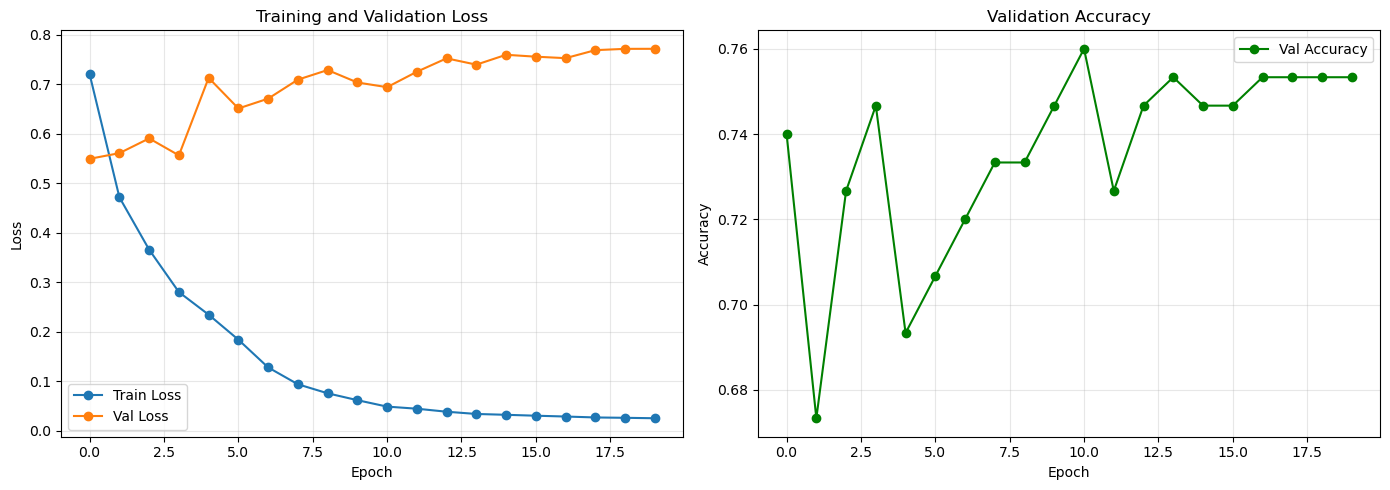


Training Summary:
Best Validation Accuracy: 0.7600 (Epoch 11)
Final Train Loss: 0.0250
Final Val Loss: 0.7718
Final Val Accuracy: 0.7533


In [54]:
# Plot training history
def plot_history(history):
    """Plot training history."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot losses
    axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
    axes[0].plot(history['val_loss'], label='Val Loss', marker='o')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot validation accuracy
    axes[1].plot(history['val_acc'], label='Val Accuracy', marker='o', color='green')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nTraining Summary:")
    print(f"{'='*60}")
    print(f"Best Validation Accuracy: {max(history['val_acc']):.4f} (Epoch {history['val_acc'].index(max(history['val_acc']))+1})")
    print(f"Final Train Loss: {history['train_loss'][-1]:.4f}")
    print(f"Final Val Loss: {history['val_loss'][-1]:.4f}")
    print(f"Final Val Accuracy: {history['val_acc'][-1]:.4f}")
    print(f"{'='*60}")

plot_history(history)

In [ ]:
# Evaluate on test set
test_acc = trainer.evaluate(test_loader)